# imports

In [2]:
import copy
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# import the working module and functions

In [3]:
from functions import *
import agglomclus as agg

# datafile

In [4]:
data = pd.read_csv("synthetic.csv")
variables = ['Var1', 'Var2']

# standardize

In [5]:
stdvar, means, variances = standardize(data, variables=variables)
for var in stdvar.columns:
    data[var] = stdvar[var]
data['std_x'] = (data['x'] - np.mean(data['x'])) / np.std(data['x'])
data['std_y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])
stdvariables = list(stdvar.columns)

In [6]:
variables, stdvariables

(['Var1', 'Var2'], ['std_Var1', 'std_Var2'])

# locmaps

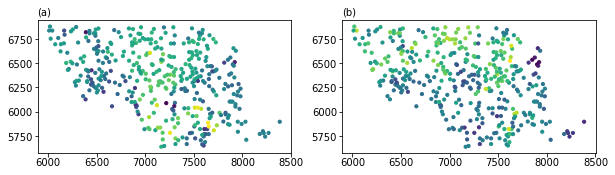

In [7]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
for iax, (var, ax) in enumerate(zip(variables, axes)):
    ax.scatter(data['x'], data['y'], c=data[var], s=10)
    fixlabels(ax)
    label_subplot(ax, iax)
    ax.set_aspect('equal')

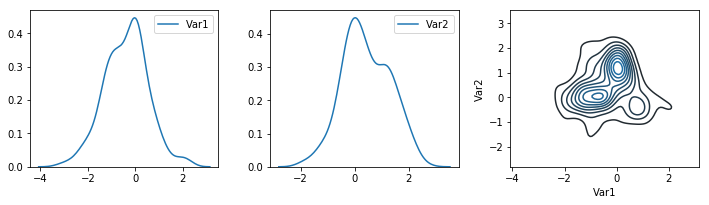

In [8]:
f, axes = plt.subplots(1, 3, figsize=(10, 3))
sns.kdeplot(data['Var1'], ax=axes[0])
sns.kdeplot(data['Var2'], ax=axes[1])
sns.kdeplot(data['Var1'], data['Var2'], ax=axes[2])
plt.tight_layout(pad=1.25)

# MV only hierarchical clustering

In [9]:
data['hier'] = cluster(3, data[variables], n_init=1, algorithm='hier') + 1

# typical hierarchical clustering with the coordinates as variables

In [10]:
hiervars = copy.copy(variables)
hiervars.insert(0, 'std_y')
hiervars.insert(0, 'std_x')
data['hier_coords'] = cluster(3, data, n_init=1, algorithm='hier') + 1
data['hier_coords'], _ = reclass_cluster_single(data['hier'], 
                                                data['hier_coords'])

# autocorr spatial clustering

In [11]:
autocorr = AutocorrClus(data[variables], data[['x', 'y']], nnears=10, 
                        clustermethod='hier', autocor='morans')
data['autocorr'] = autocorr.fit_predict(3) + 1
data['autocorr'], _ = reclass_cluster_single(data['hier'], data['autocorr'])

# agglom spatial clustering

In [12]:
agglm = agg.AgglomCluster(data[variables], data[['x', 'y']], nnears=10, stage1merge=4, 
                          niter=100, seed=77747)
agglm.fit(7, minprop=0.0001, verbose=True, ipdiff=1)

In [13]:
data['agglm'] = agglm.predict(3)
data['agglm'], _= reclass_cluster_single(data['autocorr'], data['agglm'])

# plotting

In [14]:
mdsp1 = MDSPlot(data[variables], mtype='mds', randstate=78129)
mdsp1.embed()
mdsp1.coords = data[variables].values

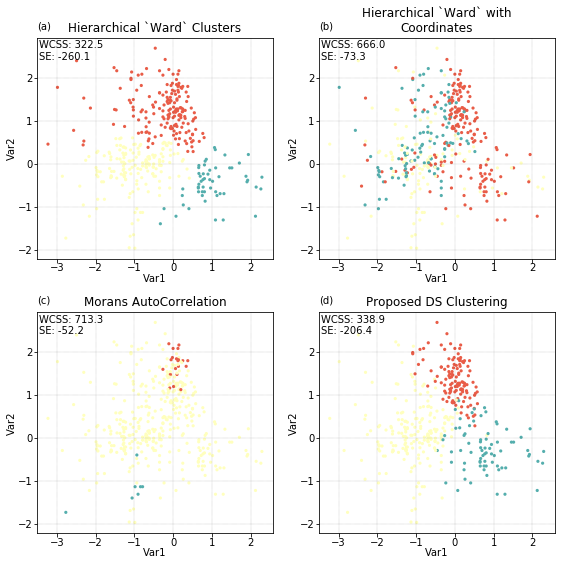

In [15]:
cols = ['hier', 'hier_coords', 'autocorr', 'agglm']
titles = ['Hierarchical `Ward` Clusters', 'Hierarchical `Ward` with\nCoordinates', 
          'Morans AutoCorrelation', 'Proposed DS Clustering']

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()
iax = 0
for ax, col, title in zip(axes, cols, titles):
    ax = mdsp1.plot_mds(colors=data[col], cmap='Spectral', pltstyle='pt7', ax=ax, 
                        title=title, legend_loc=False, s=10, lw=0.01, xlabel='Var1', 
                        ylabel='Var2')
    label_subplot(ax, fignum=iax, fontsize=10)
    agg.label_cluster_stats(data[stdvariables], data[['x', 'y']], 
                           data[col], 25, (0, 0, 0, 1, 1), ax, fontsize=10)
    iax += 1
plt.tight_layout(pad=1.25)

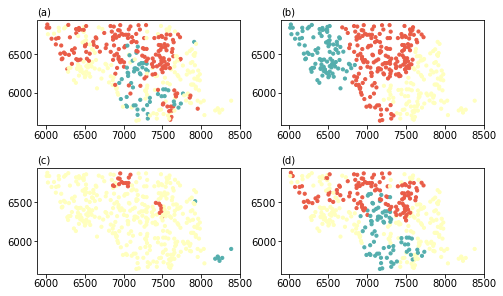

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5))
axes = axes.flatten()
iax = 0
for ax, col, title in zip(axes, cols, titles):
    ax.scatter(data['x'], data['y'], c=data[col], cmap=get_catcmap('Spectral', 3), s=10)
    fixlabels(ax)
    label_subplot(ax, iax)
    ax.set_aspect('equal')
    iax += 1